In [59]:
#import all the things!

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression, LogisticRegression 

from sklearn.svm import SVC, SVR

from sklearn.neighbors import KNeighborsClassifier , KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier


%matplotlib inline

# Intitial Data Cleaning and EDA

In [21]:
cc = pd.read_csv("data/UCI_Credit_Card.csv")

In [22]:
cc.shape

(30000, 25)

In [23]:
cc["default.payment.next.month"].value_counts()

0    23364
1     6636
Name: default.payment.next.month, dtype: int64

Luckily the dataset isn't too unbalanced, so we can likely carry on without and special sampling methods

In [24]:
cc.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


Using the dataset documentation, we can find the feature descriptions below

* ID: ID of each client
* LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit
* SEX: Gender (1=male, 2=female)
* EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
* MARRIAGE: Marital status (1=married, 2=single, 3=others)
* AGE: Age in years
* PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months
* PAY_2: Repayment status in August, 2005 (scale same as above)
* PAY_3: Repayment status in July, 2005 (scale same as above)
* PAY_4: Repayment status in June, 2005 (scale same as above)
* PAY_5: Repayment status in May, 2005 (scale same as above)
* PAY_6: Repayment status in April, 2005 (scale same as above)
* BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)
* BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)
* BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)
* BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)
* BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)
* BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)
* PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)
* PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)
* PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)
* PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)
* PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)
* PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)
* default.payment.next.month: Default payment (1=yes, 0=no)

Up next, we can run some feature correlations to see if any attributes are heavily related to each other

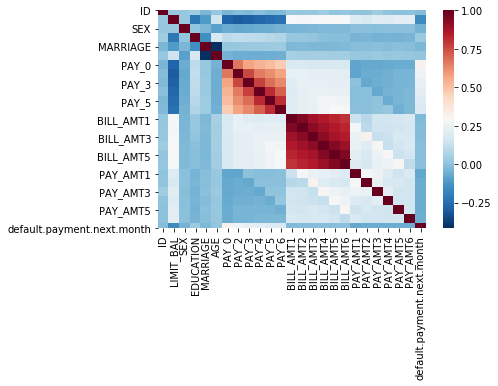

In [25]:
corel = cc.corr()
sns.heatmap(corel,cmap="RdBu_r")

It looks like there's correlation between the bill amounts over time, which isn't surprising because credit card statements transfer directly over time. The same with payment status, which also makes sense. If you're late on a payment one month, there's a likelihood that the same financial stressor may cause you to be late on future statements. 

Outside of those thoght, there a few weaker correlations to note. Mainly, higher balance limits are negatively correlated with late payments. That also makes sense, as higher credit limits are granted to people with higher credit scores (and thus assumed to be financially responsible people)

That correlation chart is hard to see though.. so we're going to break the data down into 2 sections
* Demographic information (the cardholders' sex, marriage status, education, and age)
* Financial information (i.e. all of the credit info, balance history, and payment history)

# Demographic Data

In [26]:
demographic_columns = ["SEX","MARRIAGE", "EDUCATION", "AGE"]
y = ["default.payment.next.month"]
demographic_columns_default = demographic_columns + y
demographic_columns_default

['SEX', 'MARRIAGE', 'EDUCATION', 'AGE', 'default.payment.next.month']

In [27]:
demo_data = cc[demographic_columns_default]

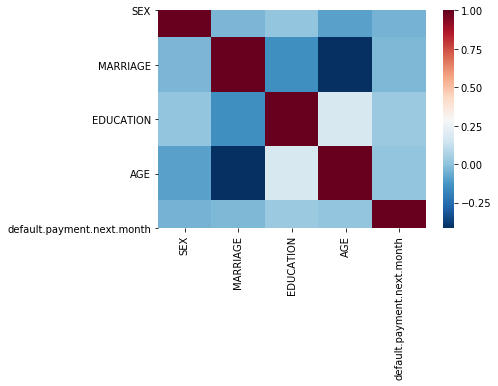

In [28]:
d_corel = demo_data.corr()
sns.heatmap(d_corel,cmap="RdBu_r")

In [29]:
def featureHist(feature, kde):
    df = cc[[feature, "default.payment.next.month"]]
    default = df[(df["default.payment.next.month"] == 1)]
    nondefault = df[(df["default.payment.next.month"] == 0)]
    
    fig = plt.figure(figsize = (10,4))
    fig.suptitle(feature)
    ax = sns.distplot(default[feature], label ="Defaults", kde = kde)
    ax = sns.distplot(nondefault[feature], label ="Non-Defaults", kde = kde)
    ax.legend()

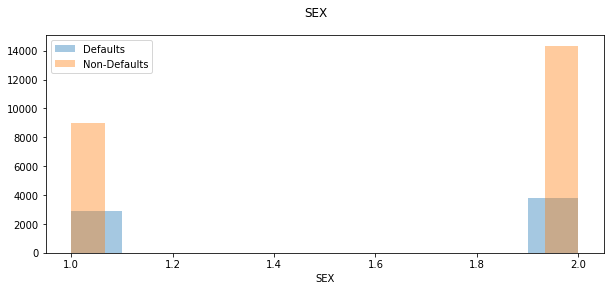

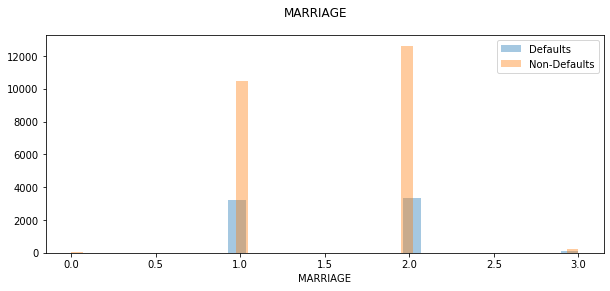

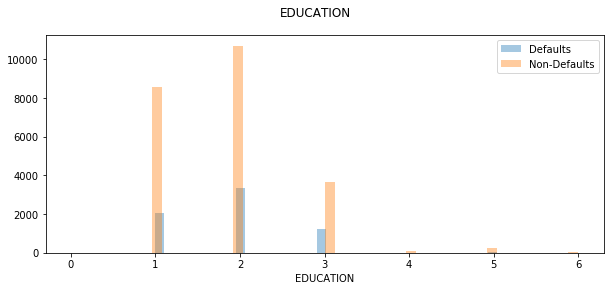

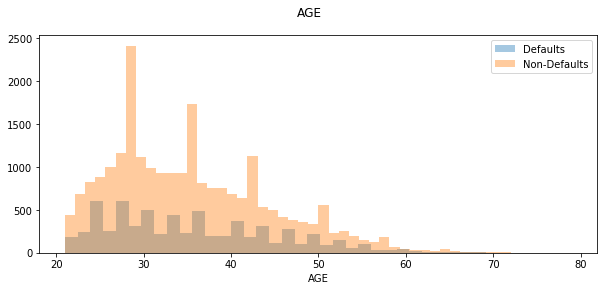

In [30]:
for feature in demographic_columns:
    featureHist(feature, False)

In [31]:
from scipy import stats

def ksCompare(feature):
    df = cc[[feature, "default.payment.next.month"]]
    default = df[(df["default.payment.next.month"] == 1)]
    nondefault = df[(df["default.payment.next.month"] == 0)]
    
    feature_defaults = default[feature].value_counts().to_frame()
    feature_defaults["% of total"] = feature_defaults[feature]/feature_defaults[feature].sum()
    #print(feature + " Defaults")
    #print(" ")
    #print(feature_defaults)
    #print(" ")
    
    feature_nondefaults = nondefault[feature].value_counts().to_frame()
    feature_nondefaults["% of total"] = feature_nondefaults[feature]/feature_nondefaults[feature].sum()
    #print(feature + " Non-Defaults")
    #print(" ")
    #print(feature_nondefaults)
    #print(" ")
    
    return stats.ks_2samp(feature_defaults[feature],feature_nondefaults[feature])

In [32]:
ksCompare("AGE")

Ks_2sampResult(statistic=0.5, pvalue=1.0056730749274934e-06)

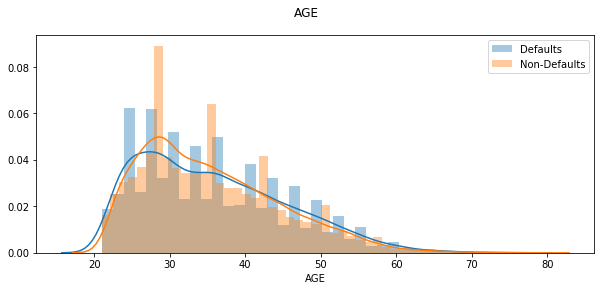

In [33]:
featureHist("AGE", True)

In [34]:
from scipy.stats import ttest_ind

df = cc[[feature, "default.payment.next.month"]]
default = df[(df["default.payment.next.month"] == 1)]
nondefault = df[(df["default.payment.next.month"] == 0)]

ttest_ind(default['AGE'], nondefault['AGE'])

Ttest_indResult(statistic=2.40594177499625, pvalue=0.01613684589016383)

In [35]:
cc_copy = cc.copy(deep=True)
cc_copy.drop(["SEX","MARRIAGE", "EDUCATION", "AGE"], axis = 1, inplace= True)

In [36]:
cc_copy.drop(["ID"], axis =1, inplace = True)

In [37]:
financial_columns = cc_copy.columns
financial_columns

Index(['LIMIT_BAL', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
       'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5',
       'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
       'PAY_AMT6', 'default.payment.next.month'],
      dtype='object')

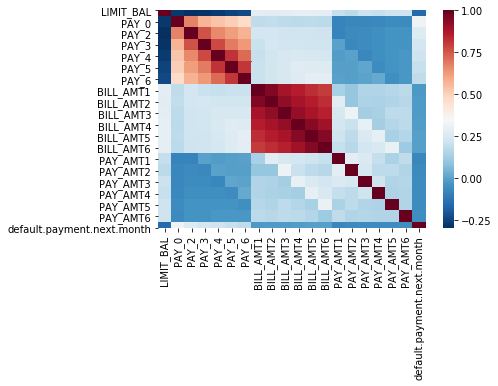

In [38]:
f_corel = cc_copy.corr()
sns.heatmap(f_corel,cmap="RdBu_r")

In [39]:
financial_columns_no_index = financial_columns[:-1]
financial_columns_no_index

Index(['LIMIT_BAL', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
       'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5',
       'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
       'PAY_AMT6'],
      dtype='object')

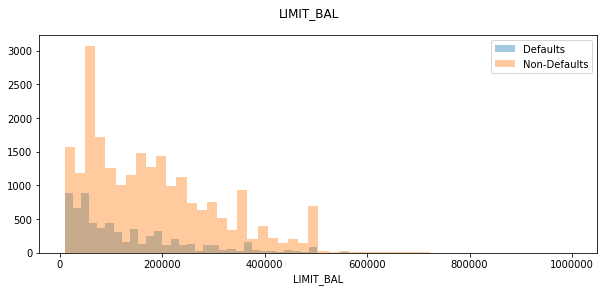

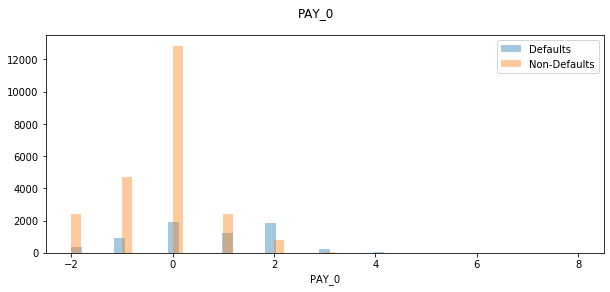

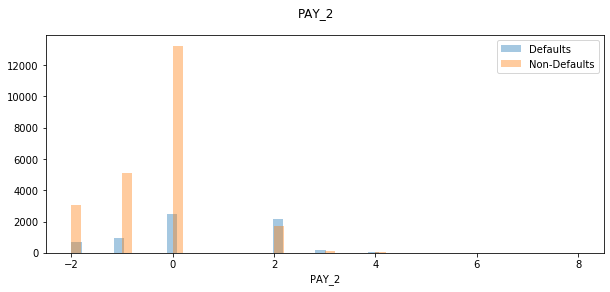

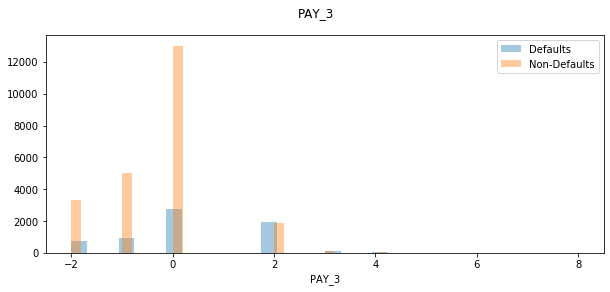

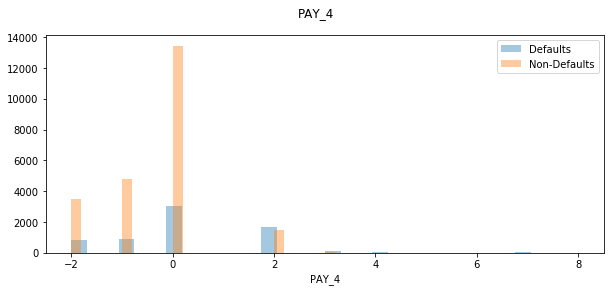

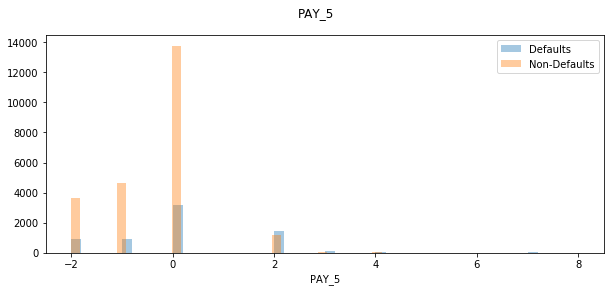

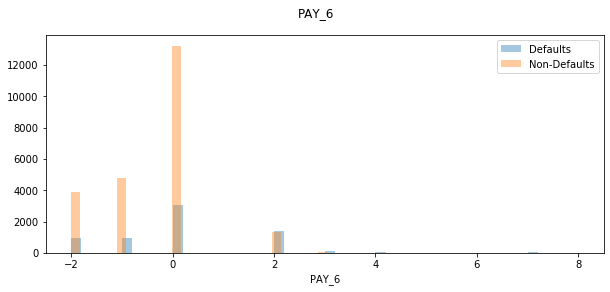

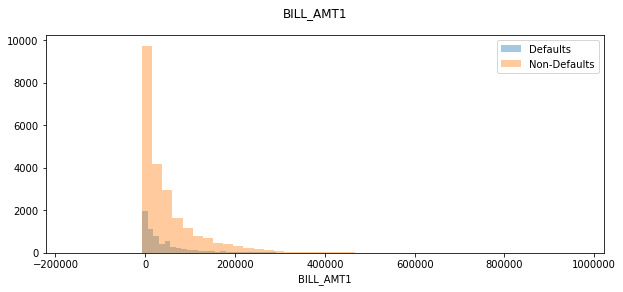

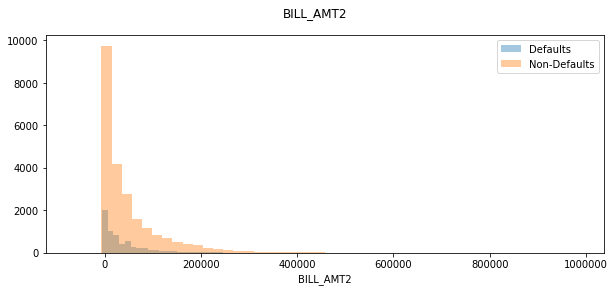

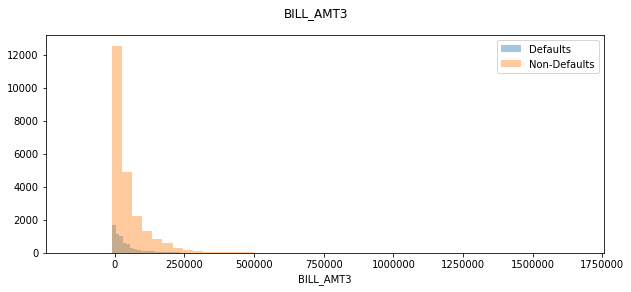

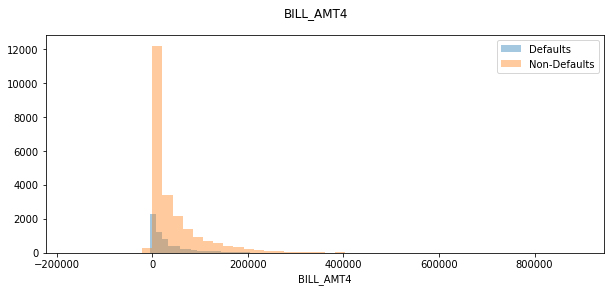

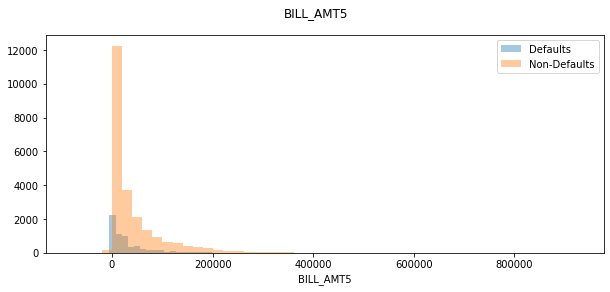

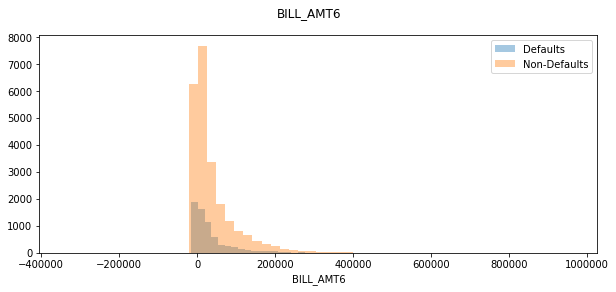

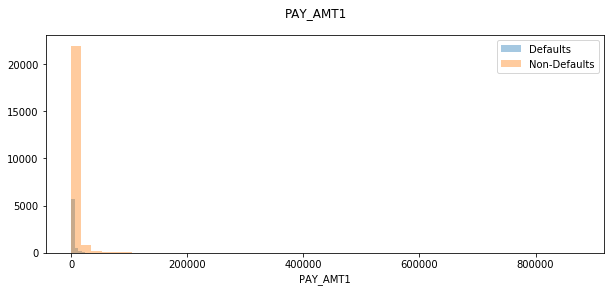

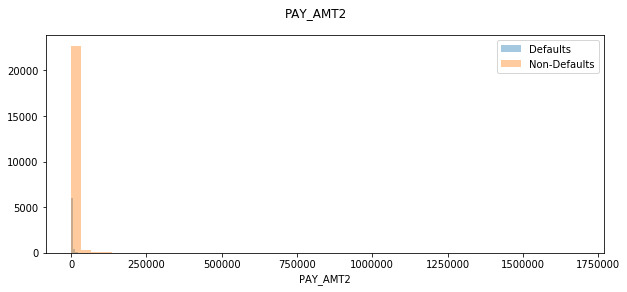

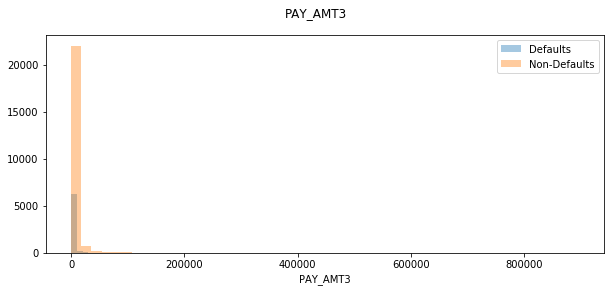

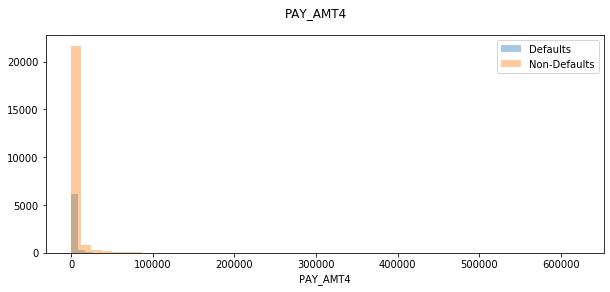

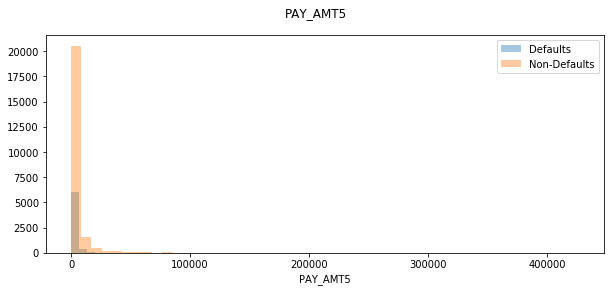

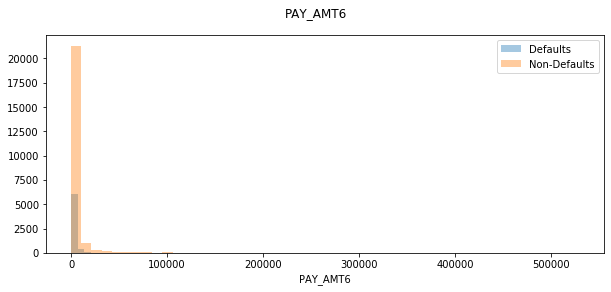

In [40]:
for feature in financial_columns_no_index:
    featureHist(feature, False)

In [41]:
for feature in financial_columns_no_index:
    print(feature)
    print(ksCompare(feature))
    print(" ")

LIMIT_BAL
Ks_2sampResult(statistic=0.3076923076923077, pvalue=0.0016379938974740993)
 
PAY_0
Ks_2sampResult(statistic=0.36363636363636365, pvalue=0.479150364599281)
 
PAY_2
Ks_2sampResult(statistic=0.2727272727272727, pvalue=0.6915847310584153)
 
PAY_3
Ks_2sampResult(statistic=0.2727272727272727, pvalue=0.832587690946824)
 
PAY_4
Ks_2sampResult(statistic=0.2727272727272727, pvalue=0.832587690946824)
 
PAY_5
Ks_2sampResult(statistic=0.3333333333333333, pvalue=0.5750719868366927)
 
PAY_6
Ks_2sampResult(statistic=0.3333333333333333, pvalue=0.5750719868366927)
 
BILL_AMT1
Ks_2sampResult(statistic=0.06891911400167583, pvalue=7.046921914154867e-18)
 
BILL_AMT2
Ks_2sampResult(statistic=0.07240381011118202, pvalue=1.5571258336649463e-19)
 
BILL_AMT3
Ks_2sampResult(statistic=0.06987465837567242, pvalue=6.316464697603726e-18)
 
BILL_AMT4
Ks_2sampResult(statistic=0.06844092462047746, pvalue=7.614529988904444e-17)
 
BILL_AMT5
Ks_2sampResult(statistic=0.070994185452392, pvalue=9.401746263948168e-18

In [42]:
default = cc[(cc["default.payment.next.month"] == 1)]
nondefault = cc[(cc["default.payment.next.month"] == 0)]

for feature in financial_columns_no_index:
    print(feature)
    print(ttest_ind(default[feature], nondefault[feature]))
    print(" ")
    

LIMIT_BAL
Ttest_indResult(statistic=-26.908521684796522, pvalue=1.3022439532597397e-157)
 
PAY_0
Ttest_indResult(statistic=59.478693408872786, pvalue=0.0)
 
PAY_2
Ttest_indResult(statistic=47.3198598460159, pvalue=0.0)
 
PAY_3
Ttest_indResult(statistic=41.92214741668765, pvalue=0.0)
 
PAY_4
Ttest_indResult(statistic=38.42975367280759, pvalue=0.0)
 
PAY_5
Ttest_indResult(statistic=36.119124791582685, pvalue=1.1266079544980244e-279)
 
PAY_6
Ttest_indResult(statistic=32.945447107608864, pvalue=7.29674048327923e-234)
 
BILL_AMT1
Ttest_indResult(statistic=-3.403018001170964, pvalue=0.0006673295491221741)
 
BILL_AMT2
Ttest_indResult(statistic=-2.458503181278919, pvalue=0.013957362392434761)
 
BILL_AMT3
Ttest_indResult(statistic=-2.4381115045173596, pvalue=0.014769982710723002)
 
BILL_AMT4
Ttest_indResult(statistic=-1.759188785998342, pvalue=0.07855564157651403)
 
BILL_AMT5
Ttest_indResult(statistic=-1.1709344117538458, pvalue=0.24163444291382874)
 
BILL_AMT6
Ttest_indResult(statistic=-0.9304

In [54]:
X = cc.copy(deep=True)

In [55]:
y = cc["default.payment.next.month"]

In [56]:
logreg = LogisticRegression(max_iter = 1000)
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [57]:
logreg.fit(X_train, y_train)
logreg.score(X_test, y_test)

0.7794666666666666

In [61]:
rf = RandomForestClassifier()
X_train, X_test, y_train, y_test = train_test_split(X,y)

rf.fit(X_train, y_train)
rf.score(X_test, y_test)

1.0